In [1]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

# set random seed
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)


### load sample image

[[ 53.         68.0000175 405.        478.9998225   0.       ]
 [202.         20.99992   496.        486.99978     0.       ]
 [589.         77.0001275 737.        335.9999825   0.       ]
 [723.        327.000125  793.        396.000295    1.       ]]


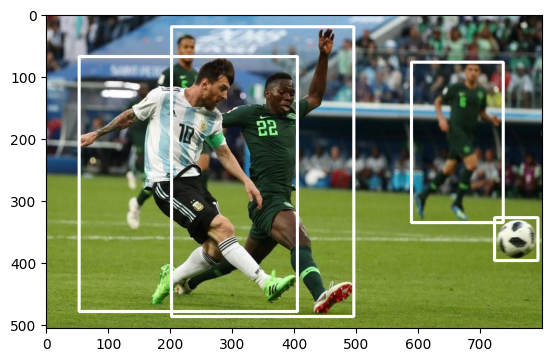

In [2]:
img = cv2.imread("messi.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = pkl.load(open("messi_ann.pkl", "rb"))

#inspect the bounding boxes
print(bboxes)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

### load TA image from `2023-datalab-cup2-object-detection/pascal_voc_training_data.txt`
- format of `2023-datalab-cup2-object-detection/pascal_voc_training_data.txt`:
```
000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
```

In [3]:
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                "bus", "car", "cat", "chair", "cow",
                "diningtable", "dog", "horse", "motorbike", "person",
                "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
# class_collector is a dictionary that accumulates the number of bounding boxes for each class
class_lib = {}

In [4]:
train_dataset_bboxes_path = '../2023-datalab-cup2-object-detection/pascal_voc_training_data.txt'
bbox_lib = {}
augmented_time = {}

image_name_list = []
object_num_list = []
object_class_list = []

with open(train_dataset_bboxes_path) as f:
    train_dataset_bboxes = f.readlines()
    # read out all the bboxes
    cnt = 0
    for line in train_dataset_bboxes:
        line = line.strip().split()
        # print(line)
        
        # 0: image name
        # rest: bboxes
        img_name = line[0]
        tmp_ls = []
        local_object_class_list = []
        
        bbox = line[1:]
    
        image_name_list.append(img_name)
        object_num_list.append(len(bbox)//5)
        # for each bbox, we have 5 elements.
        for i in range(len(bbox)//5):
            # convert it from string to int
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
            class_type = int(bbox[i*5+4])
            local_object_class_list.append(class_type)
            class_name = classes_name[class_type]
            if class_name not in class_lib:
                class_lib[class_name] = 1
            else:
                class_lib[class_name] += 1
        # convert tmp_ls to np array
        tmp_ls = np.array(tmp_ls)
        bbox_lib[img_name] = tmp_ls
        # oject class list
        object_class_list.append(local_object_class_list)
        augmented_time[img_name] = 1
        

### analyze distribution

In [5]:
class_count = np.zeros(20, int)
for row in range(5):
    for col in range(4):
        index = row*4+col
        class_count[index] = class_lib[classes_name[index]]
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} {class_lib[class_name]:8d} {class_count[index]:5d}', end='<|')
    print()

   0) aeroplane         331   331<|   1) bicycle           417   417<|   2) bird              599   599<|   3) boat              398   398<|
   4) bottle            629   629<|   5) bus               272   272<|   6) car              1636  1636<|   7) cat               389   389<|
   8) chair            1425  1425<|   9) cow               356   356<|  10) diningtable       309   309<|  11) dog               536   536<|
  12) horse             403   403<|  13) motorbike         390   390<|  14) person           5392  5392<|  15) pottedplant       620   620<|
  16) sheep             353   353<|  17) sofa              419   419<|  18) train             328   328<|  19) tvmonitor         366   366<|


In [6]:
rep_class_lib = class_lib.copy()
lower_bound = 3000
# sort and be descending
descend_object_num_index = np.argsort(object_num_list)[::-1]
invalid_ele = np.zeros(len(object_num_list), int)

while True:
    for i in descend_object_num_index:
        local_object_class_list = object_class_list[i]
        if invalid_ele[i] or (class_count[local_object_class_list] >= lower_bound).any():
            invalid_ele[i] = 1
            continue
        else:
            augmented_time[image_name_list[i]] += 1
            for c in local_object_class_list:
                class_count[c] += 1
    if (class_count >= lower_bound).all():
        break

In [7]:
# sum up the augmented time
augmented_time_sum = 0
for k, v in augmented_time.items():
    augmented_time_sum += v
    
# sum up the original version
original_time_sum = 0
for k, v in class_lib.items():
    original_time_sum += v
print(f'augmented time sum: {augmented_time_sum}')
print(f'original time sum: {original_time_sum}')

# output the max augmented time
max_augmented_time = 0
max_augmented_time_img_name = ''
for k, v in augmented_time.items():
    if v > max_augmented_time:
        max_augmented_time = v
        max_augmented_time_img_name = k
print(f'max augmented time: {max_augmented_time}')

for row in range(5):
    for col in range(4):
        index = row*4+col
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} orig.: {class_lib[class_name]:8d} aug.: {class_count[index]:5d}', end='<|')
    print()

augmented time sum: 32814
original time sum: 15568
max augmented time: 406
   0) aeroplane    orig.:      331 aug.:  3001<|   1) bicycle      orig.:      417 aug.:  3000<|   2) bird         orig.:      599 aug.:  3000<|   3) boat         orig.:      398 aug.:  3000<|
   4) bottle       orig.:      629 aug.:  3000<|   5) bus          orig.:      272 aug.:  3000<|   6) car          orig.:     1636 aug.:  3001<|   7) cat          orig.:      389 aug.:  3000<|
   8) chair        orig.:     1425 aug.:  3003<|   9) cow          orig.:      356 aug.:  3002<|  10) diningtable  orig.:      309 aug.:  3000<|  11) dog          orig.:      536 aug.:  3000<|
  12) horse        orig.:      403 aug.:  3000<|  13) motorbike    orig.:      390 aug.:  3000<|  14) person       orig.:     5392 aug.:  5392<|  15) pottedplant  orig.:      620 aug.:  3000<|
  16) sheep        orig.:      353 aug.:  3007<|  17) sofa         orig.:      419 aug.:  3001<|  18) train        orig.:      328 aug.:  3000<|  19) tvm

### peek at a single image result

[[ 81. 279. 207. 356.   1.]]


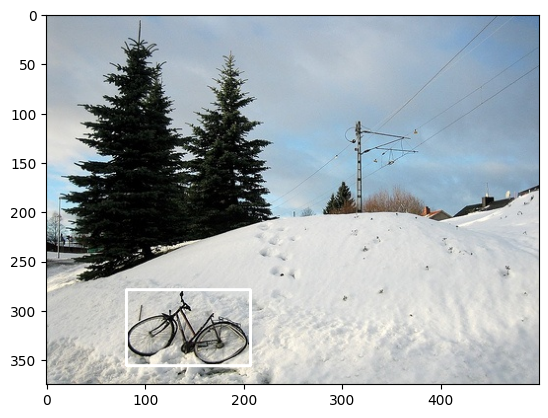

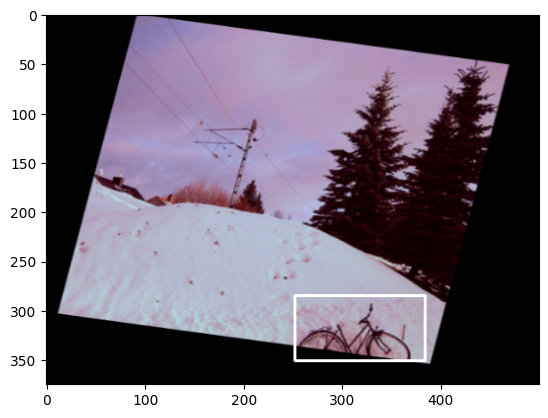

In [8]:
train_dataset_folder = '../2023-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'
image_name = '001184.jpg'

img = cv2.imread(train_dataset_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = bbox_lib[image_name]
print(bboxes)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

### create dst folder if not exist and copy bbox_lib into new_bbox_lib

In [9]:
train_dataset_folder = '../2023-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'
dst_folder = './augmented_unbalance_images/'
# create the folder if not exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# list out all the images in the train_dataset_folder
train_dataset_images = os.listdir(train_dataset_folder)
# new_bbox_lib copy from bbox_lib. It is used to hold the augmented bboxes and the original bboxes
new_bbox_lib = bbox_lib.copy()

### apply augumentation one by one without balance
- the data is formed by np array, where each unit is a 5-element tuple
  - `[x_1,y_1,x_2,y_2, c]`, and `x_1...c` is float
- the balance can be traced by `c`. Use c's distribution to determine whether we should apply augumentation

In [10]:
# Define the path to the pickle file
pickle_file_path = 'augmented_unbalance_bboxes.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file_path):
    # Load the new_bbox_lib from the pickle file
    with open(pickle_file_path, 'rb') as f:
        new_bbox_lib = pkl.load(f)
    print("Loaded augmented data from pickle file. Skipping augmentation.")
else:
    # handle them one by one
    for image in tqdm(train_dataset_images, desc="Processing images"):
        # read the image
        # img = cv2.imread(train_dataset_folder + image)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
        img = tf.io.read_file(train_dataset_folder + image)
        img = tf.image.decode_jpeg(img, channels=3)
        # get the bboxes
        if image not in bbox_lib:
            continue
        bboxes = bbox_lib[image]
        
        # TODO: USE C'S DISTRIBUTION TO DETERMINE WHETHER TO AUGMENT THE IMAGE OR NOT
        # get the total number of repeated times
        repeated_times = augmented_time[image]
        # save the original image
        img_ = tf.image.encode_jpeg(img)
        tf.io.write_file(dst_folder+image, img_)
        
        # print(f'{image} repeated times: {repeated_times}')
        repeated_times -= 1
        
        for i in range(0, repeated_times):
            # augment the image
            tmp = img.numpy().copy()
            # add random noise over the image
            noise = np.random.normal(0, 10, tmp.shape).astype(np.uint8)
            tmp = tmp + noise
            deg = i % 180
            seq = Sequence([RandomHSV(30, 40, 50),RandomHorizontalFlip(0.7), RandomScale(0.1), RandomShear(0.15), RandomRotate(deg)])
            img_, bboxes_ = seq(tmp, bboxes.copy())
            if len(bboxes_) == 0:
                continue
            new_name = 'aug_'+ str(i) + '_' + image
            # make sure img_ is greater or equal to 0
            img_[img_ < 0] = 0
            # make sure bboxes_ is greater or equal to 0
            bboxes_[bboxes_ < 0] = 0
            # make img_ is less or equal to 255
            img_[img_ > 255] = 255
            img_ = tf.image.encode_jpeg(img_)
            tf.io.write_file(dst_folder+new_name, img_)
            # save the bboxes into the new_bbox_lib
            new_bbox_lib[new_name] = bboxes_

    # convert all bboxes in new_bbox_lib to int
    for key, value in new_bbox_lib.items():
        # convert value as int type
        value = value.astype(int)
        new_bbox_lib[key] = value

    # save the new_bbox_lib
    with open(pickle_file_path, 'wb') as f:
        pkl.dump(new_bbox_lib, f)
    print("Augmentation completed and data saved to pickle file.")

Loaded augmented data from pickle file. Skipping augmentation.


In [11]:
# print(new_bbox_lib['009926.jpg'])
# write the new_bbox_lib into a txt file
new_bbox_lib_path = './augmented_unbalance_images.txt'
with open(new_bbox_lib_path, 'w') as f:
    for key, value in new_bbox_lib.items():
        f.write(key)
        f.write(' ')
        for bbox in value:
            for element in bbox:
                f.write(str(element))
                f.write(' ')
        f.write('\n')

### verify the augmeunted_unbalance_images.txt and the image

In [12]:
# first read the augmented_unbalance_images.txt
augmented_unbalance_images_path = './augmented_unbalance_images.txt'
test_bbox_lib = {}

with open(augmented_unbalance_images_path) as f:
    buffer = f.readlines()
    for line in buffer:
        line = line.strip().split()
        image_name = line[0]
        tmp_ls = []
        bbox = line[1:]
        for i in range(len(bbox)//5):
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
        tmp_ls = np.array(tmp_ls)
        test_bbox_lib[image_name] = tmp_ls

### compare `001898.jpg`
- the original version contains 3 but the converted version only holds two
- I think it is normal, for the converted version experiences cropping

002893.jpg
[  1.   6. 494. 375.  13.] motorbike


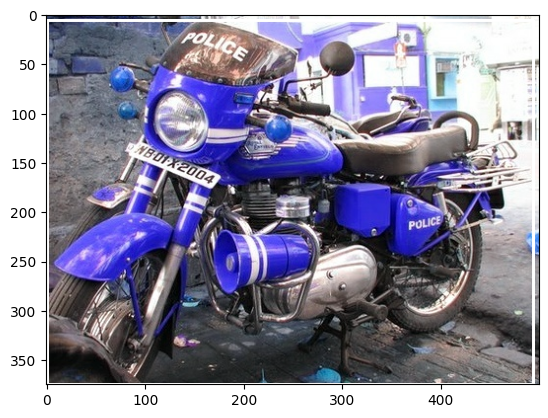

In [13]:
augumented_unbalance_images_folder = './augmented_unbalance_images/'
image_name = '002893.jpg'

img = cv2.imread(augumented_unbalance_images_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = test_bbox_lib[image_name]
print(image_name)
for bbox in bboxes:
    print(bbox, classes_name[int(bbox[4])])
# convert img from bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

aug_15_002893.jpg
[  6.   5. 500. 375.  13.] motorbike


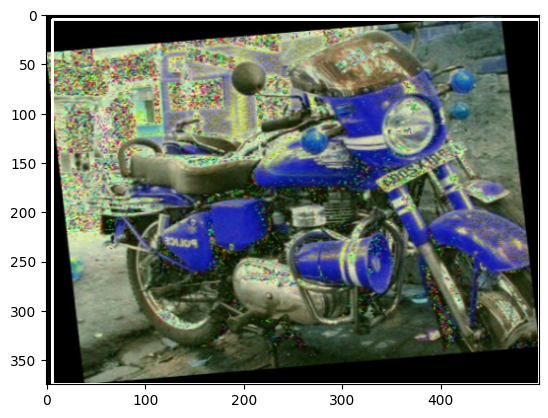

In [14]:
augumented_unbalance_images_folder = './augmented_unbalance_images/'
image_name = 'aug_15_002893.jpg'

img = cv2.imread(augumented_unbalance_images_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = test_bbox_lib[image_name]
print(image_name)
# convert img from bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for bbox in bboxes:
    print(bbox, classes_name[int(bbox[4])])
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

In [15]:
train_dataset_bboxes_path = 'augmented_unbalance_images.txt'
bbox_lib = {}
augmented_time = {}

image_name_list = []
object_num_list = []
object_class_list = []

with open(train_dataset_bboxes_path) as f:
    train_dataset_bboxes = f.readlines()
    # read out all the bboxes
    cnt = 0
    for line in train_dataset_bboxes:
        line = line.strip().split()
        # print(line)
        
        # 0: image name
        # rest: bboxes
        img_name = line[0]
        tmp_ls = []
        local_object_class_list = []
        
        bbox = line[1:]
    
        image_name_list.append(img_name)
        object_num_list.append(len(bbox)//5)
        # for each bbox, we have 5 elements.
        for i in range(len(bbox)//5):
            # convert it from string to int
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
            class_type = int(bbox[i*5+4])
            local_object_class_list.append(class_type)
            class_name = classes_name[class_type]
            if class_name not in class_lib:
                class_lib[class_name] = 1
            else:
                class_lib[class_name] += 1
        # convert tmp_ls to np array
        tmp_ls = np.array(tmp_ls)
        bbox_lib[img_name] = tmp_ls
        # oject class list
        object_class_list.append(local_object_class_list)
        augmented_time[img_name] = 1


In [16]:
class_count = np.zeros(20, int)
for row in range(5):
    for col in range(4):
        index = row*4+col
        class_count[index] = class_lib[classes_name[index]]
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} {class_lib[class_name]:8d} {class_count[index]:5d}', end='<|')
    print()

   0) aeroplane        3331  3331<|   1) bicycle          3417  3417<|   2) bird             3595  3595<|   3) boat             3383  3383<|
   4) bottle           3620  3620<|   5) bus              3267  3267<|   6) car              4623  4623<|   7) cat              3389  3389<|
   8) chair            4416  4416<|   9) cow              3358  3358<|  10) diningtable      3308  3308<|  11) dog              3535  3535<|
  12) horse            3403  3403<|  13) motorbike        3390  3390<|  14) person          10784 10784<|  15) pottedplant      3608  3608<|
  16) sheep            3330  3330<|  17) sofa             3420  3420<|  18) train            3324  3324<|  19) tvmonitor        3364  3364<|


In [17]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [18]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i > 5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [19]:
import tensorflow as tf
import numpy as np

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [21]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 4 # original 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
# DATA_PATH = './pascal_voc_training_data.txt'
# IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

DATA_PATH = './augmented_unbalance_images.txt'
IMAGE_DIR = './augmented_unbalance_images/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 40 # original 20

In [22]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

In [25]:
resnet50 = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
)
# resnet50.trainable = False

In [26]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet50(img_inputs)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [27]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 1024)      18875392  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 1024)      9438208   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 1024)        9438208

In [28]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [29]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [30]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [31]:
dataset = DatasetGenerator().generate()

In [32]:
import matplotlib.pyplot as plt
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


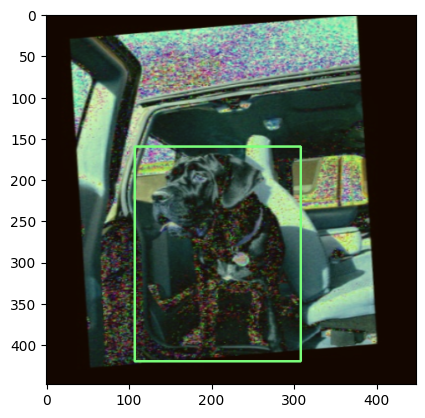

In [33]:
for idx, (image, labels, objects_num) in enumerate(dataset):
    img = np.array(image[0])
    labels = labels[0]
    n = objects_num[0]
    for i in range(n):
      label = labels[i]
      print(classes_name[int(label[4])])
      x, y = int(label[0]),int(label[1]) 
      w, h = int(label[2]), int(label[3])
      cv2.rectangle(img, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 2)
    plt.imshow((img - np.min(img))/255)
    break

In [34]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [35]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

# Define the checkpoint directory
checkpoint_dir = '../ckpts/YOLO'

# Create the directory if it does not exist
os.makedirs(checkpoint_dir, exist_ok=True)

manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=10,
                                     checkpoint_name='yolo')

In [36]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [37]:
from datetime import datetime
from tqdm import tqdm

In [38]:
# Restore the latest checkpoint if it exists
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint)
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Restored from ../ckpts/YOLO\yolo-24


In [39]:
print("{}, start training.".format(datetime.now()))
for i in range(int(ckpt.epoch), EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    # Set the total number of iterations for tqdm
    total_iterations = len(dataset)

    for idx, (image, labels, objects_num) in tqdm(enumerate(dataset), desc=f"Epoch {i+1}/{EPOCHS}", total=total_iterations):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2024-11-04 00:48:24.948077, start training.


Epoch 25/40: 100%|██████████| 8203/8203 [41:53<00:00,  3.26it/s]


2024-11-04 01:30:18.002364, Epoch 25: loss 1.12
Saved checkpoint for epoch 25: ../ckpts/YOLO\yolo-25


Epoch 26/40: 100%|██████████| 8203/8203 [42:22<00:00,  3.23it/s]


2024-11-04 02:12:43.678403, Epoch 26: loss 1.11
Saved checkpoint for epoch 26: ../ckpts/YOLO\yolo-26


Epoch 27/40: 100%|██████████| 8203/8203 [42:24<00:00,  3.22it/s]


2024-11-04 02:55:10.781199, Epoch 27: loss 1.11
Saved checkpoint for epoch 27: ../ckpts/YOLO\yolo-27


Epoch 28/40: 100%|██████████| 8203/8203 [42:21<00:00,  3.23it/s]


2024-11-04 03:37:34.683654, Epoch 28: loss 1.10
Saved checkpoint for epoch 28: ../ckpts/YOLO\yolo-28


Epoch 29/40: 100%|██████████| 8203/8203 [41:26<00:00,  3.30it/s]


2024-11-04 04:19:04.553182, Epoch 29: loss 1.09
Saved checkpoint for epoch 29: ../ckpts/YOLO\yolo-29


Epoch 30/40: 100%|██████████| 8203/8203 [41:15<00:00,  3.31it/s]


2024-11-04 05:00:22.754524, Epoch 30: loss 1.09
Saved checkpoint for epoch 30: ../ckpts/YOLO\yolo-30


Epoch 31/40: 100%|██████████| 8203/8203 [41:10<00:00,  3.32it/s]


2024-11-04 05:41:36.650671, Epoch 31: loss 1.07
Saved checkpoint for epoch 31: ../ckpts/YOLO\yolo-31


Epoch 32/40: 100%|██████████| 8203/8203 [41:07<00:00,  3.32it/s]


2024-11-04 06:22:47.250985, Epoch 32: loss 1.07
Saved checkpoint for epoch 32: ../ckpts/YOLO\yolo-32


Epoch 33/40: 100%|██████████| 8203/8203 [41:09<00:00,  3.32it/s]


2024-11-04 07:03:59.423280, Epoch 33: loss 1.09
Saved checkpoint for epoch 33: ../ckpts/YOLO\yolo-33


Epoch 34/40: 100%|██████████| 8203/8203 [41:07<00:00,  3.33it/s]


2024-11-04 07:45:09.396999, Epoch 34: loss 1.05
Saved checkpoint for epoch 34: ../ckpts/YOLO\yolo-34


Epoch 35/40: 100%|██████████| 8203/8203 [41:08<00:00,  3.32it/s]


2024-11-04 08:26:20.860712, Epoch 35: loss 1.06
Saved checkpoint for epoch 35: ../ckpts/YOLO\yolo-35


Epoch 36/40: 100%|██████████| 8203/8203 [41:03<00:00,  3.33it/s]


2024-11-04 09:07:27.056735, Epoch 36: loss 1.05
Saved checkpoint for epoch 36: ../ckpts/YOLO\yolo-36


Epoch 37/40: 100%|██████████| 8203/8203 [40:59<00:00,  3.34it/s]


2024-11-04 09:48:29.330552, Epoch 37: loss 1.05
Saved checkpoint for epoch 37: ../ckpts/YOLO\yolo-37


Epoch 38/40: 100%|██████████| 8203/8203 [41:00<00:00,  3.33it/s]


2024-11-04 10:29:33.145179, Epoch 38: loss 1.04
Saved checkpoint for epoch 38: ../ckpts/YOLO\yolo-38


Epoch 39/40: 100%|██████████| 8203/8203 [40:54<00:00,  3.34it/s]


2024-11-04 11:10:30.355575, Epoch 39: loss 1.04
Saved checkpoint for epoch 39: ../ckpts/YOLO\yolo-39


Epoch 40/40: 100%|██████████| 8203/8203 [40:45<00:00,  3.35it/s]


2024-11-04 11:51:18.700722, Epoch 40: loss 1.03
Saved checkpoint for epoch 40: ../ckpts/YOLO\yolo-40


In [ ]:
def IOU(rect1, rect2):
    xmin1, ymin1, xmax1, ymax1 = rect1
    xmin2, ymin2, xmax2, ymax2 = rect2
    s1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    s2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    sum_area = s1 + s2

    left = max(xmin2, xmin1)
    right = min(xmax2, xmax1)
    top = max(ymin2, ymin1)
    bottom = min(ymax2, ymax1)

    if left >= right or top >= bottom:
        return 0

    intersection = (right - left) * (bottom - top)
    return intersection / (sum_area - intersection ) * 1.0

def process_outputs(outputs, confidence_threshold, iou_threshold):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    #max_conf = np.max(P)
    #index = np.argmax(P)

    xmin_l = []
    ymin_l = []
    xmax_l = []
    ymax_l = []
    class_num_l = []
    conf_l = []

    indexs = np.argsort(P.reshape(-1))[::-1][:]
    disabled = np.zeros(indexs.shape)
    
    for i, index in enumerate(indexs):
        if disabled[i]:
            continue
        index = np.unravel_index(index, P.shape)
        if P[index]<confidence_threshold and i != 0:
            break

        class_num = index[3]
        class_num_l.append(index[3])

        coordinate = np.reshape(coordinate, 
                                (CELL_SIZE, 
                                CELL_SIZE,
                                BOXES_PER_CELL, 
                                4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        xmin_l.append(xmin)
        ymin_l.append(ymin)
        xmax_l.append(xmax)
        ymax_l.append(ymax)
        class_num_l.append(class_num)
        conf_l.append(P[index])

        for j in range(i+1, len(indexs)):
            o_i = indexs[j]
            o_index = np.unravel_index(o_i, P.shape)
            o_class = o_index[3]
            if o_class != class_num:
                continue

            o_max_coordinate = coordinate[o_index[0], o_index[1], o_index[2], :]
            o_xcenter = o_max_coordinate[0]
            o_ycenter = o_max_coordinate[1]
            o_w = o_max_coordinate[2]
            o_h = o_max_coordinate[3]
            o_xcenter = (o_index[1] + o_xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
            o_ycenter = (o_index[0] + o_ycenter) * (IMAGE_SIZE/float(CELL_SIZE))
            o_w = o_w * IMAGE_SIZE
            o_h = o_h * IMAGE_SIZE
            o_xmin = o_xcenter - o_w/2.0
            o_ymin = o_ycenter - o_h/2.0
            o_xmax = o_xmin + o_w
            o_ymax = o_ymin + o_h
            if(IOU((xmin, ymin, xmax, ymax), (o_xmin, o_ymin, o_xmax, o_ymax)) > iou_threshold):
                disabled[j] = True

    return xmin_l, ymin_l, xmax_l, ymax_l, class_num_l, conf_l
    #return xmin, ymin, xmax, ymax, class_num, max_conf

In [42]:
#ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('../ckpts/YOLO/yolo-40')

In [43]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = '../2023-datalab-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [44]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [45]:
import matplotlib.pyplot as plt
import cv2

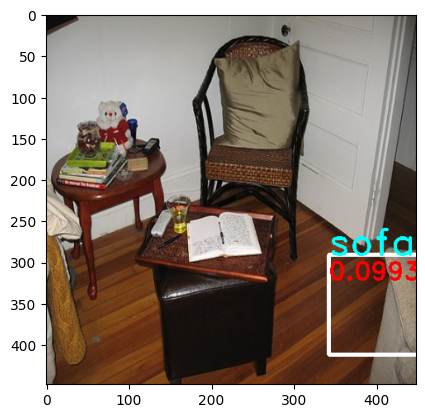

In [50]:
np_img = cv2.imread('../2023-datalab-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/000008.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = tf.keras.applications.resnet.preprocess_input(np_img)

np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred, 0.1, 0.5)

for i in range(len(xmin)):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (255, 255, 255), 3)
    cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
    cv2.putText(resized_img, str(conf[i]), (int(xmin[i]), int(ymin[i]+30)), 2, 1, (255, 0, 0), 2)
plt.imshow(resized_img)
plt.show()

In [55]:
import sys

sys.path.insert(0, './evaluate')
import evaluate
import pandas as pd

In [ ]:
# Create a list that lists confidence thresholds from 0.02 to 0.04
confidence_thresholds = [0.010 + 0.002*i for i in range(10)]
# Create a list that lists IoU thresholds from 0.4 to 0.58
iou_thresholds = [0.4 + 0.02*i for i in range(10)]

# Run a for loop to get the best confidence threshold and IoU threshold
for confidence_threshold in confidence_thresholds:
    for iou_threshold in iou_thresholds:
        print('confidence_threshold: {:f}, iou_threshold: {:f}'.format(confidence_threshold, iou_threshold))
        output_file = open('./test_prediction.txt', 'w')

        for img_name, test_img, img_h, img_w in tqdm(test_dataset, desc="Processing Images", leave=False):
            batch_num = img_name.shape[0]
            for i in range(batch_num):
                output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
                xmin_l, ymin_l, xmax_l, ymax_l, class_num_l, conf_l = process_outputs(prediction_step(test_img[i:i+1]), confidence_threshold, iou_threshold)
                for j in range(len(xmin_l)):
                    class_num = class_num_l[j]
                    conf = conf_l[j]
                    xmin, ymin, xmax, ymax = xmin_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin_l[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax_l[j]*(img_h[i:i+1]/IMAGE_SIZE)
                    output_file.write(" %d %d %d %d %d %f" % (xmin, ymin, xmax, ymax, class_num, conf))
                output_file.write("\n")

        output_file.close()
        evaluate.evaluate('./test_prediction.txt', './output_file.csv')

        cap = pd.read_csv('./output_file.csv')['packedCAP']
        # Write the data into a file
        with open('./hyperparameter_tuning.txt', 'a') as f:
            f.write('confidence_threshold: {:f}, iou_threshold: {:f}\n'.format(confidence_threshold, iou_threshold))
            f.write('score: {:f}\n'.format(sum((1. - cap) ** 2) / len(cap)))

Confidence Thresholds:   0%|          | 0/10 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
output_file = open('./test_prediction.txt', 'w')
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        xmin_l, ymin_l, xmax_l, ymax_l, class_num_l, conf_l = process_outputs(prediction_step(test_img[i:i+1]), 0.0005, 0.42)
        for j in range(len(xmin_l)):
            class_num = class_num_l[j] 
            conf = conf_l[j]
            xmin, ymin, xmax, ymax = xmin_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin_l[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax_l[j]*(img_h[i:i+1]/IMAGE_SIZE)
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))
        output_file.write("\n")

output_file.close()

evaluate.evaluate('./test_prediction.txt', './output_file.csv')
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.392024


In [ ]:
evaluate.evaluate('./test_prediction.txt', './output_file.csv')
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.392024
